## **Bug Classification**: A Text Classification Approach for Bug Identification
#### **Problem Statement**:
Our research aims to develop a system that automates the identification of similar bugs and their categorization into predefined classes within extensive bug report datasets. By leveraging natural language processing and machine learning techniques, the system streamlines the bug tracking process, enabling software developers to efficiently allocate resources, prioritize critical issues, and enhance the overall software quality.

#### **Motivation**:
Our research is motivated by the critical demand within the software industry for more efficient bug management systems. With software systems becoming increasingly complex and the number of bug reports growing rapidly, software development teams face significant challenges in effectively addressing these issues. By automating bug classification processes, our goal is to streamline bug management workflows, minimize manual intervention, and accelerate bug resolution, thereby enhancing overall software development productivity.

#### **Code Overview**:
In the following Python notebook, we have included the code related to bug classification, covering the following topics:
*   Data Balancing
*   Data Pre-processing
*   TF-IDF and Random Forest Classifiers
*   Using Word2Vec and Random Forest Classifiers
*   Naive Bayes and TF-IDF
*   TF-IDF with LR Model
*   Word2Vec and MLP
*   WordCloud Graph Plotting for Analysis on Train Data
*   Graph for Word Count Analysis in Title and Description
*   Graph Analysis on the Different Datasets
*   DistilBERT Implementation for Classification




*Following is the code for Data balancing. The top 8000 rows of top 5 components are considered. For testing entire file please update the number of rows from 8000 rows to 10.*

In [68]:
import pandas as pd

max_number_of_rows = 8000 # Maximum number of components to be considered.
max_number_of_components = 5 # Maximum number of components to be considered.
file_name = "mozilla_core.csv" # Update this for any other file which should have "Component", "Title", "Description" columns.

df = pd.read_csv(file_name)
comp_set = set(df['Component'])
matrix = dict()
for i in comp_set:
    df_i = df[df["Component"] == i]
    matrix[i] = df_i.shape[0]
print(sorted(matrix.items(), key=lambda i: i[1]))

df["Component"] = df["Component"].str.split().str.get(0).str.split(":").str.get(0)
componets = df.explode("Component")["Component"].value_counts()
componets_top = componets.head(max_number_of_components).index.tolist()
df = df[df["Component"].apply(lambda x: x in componets_top)]
df_filter = pd.DataFrame(columns=df.columns)
for i in componets_top:
    componets_rows = df[df["Component"].apply(lambda x: x == i)].head(max_number_of_rows)
    df_filter = pd.concat([df_filter, componets_rows])
df = df_filter
df = df.sample(frac=1, random_state=50).reset_index(drop=True)

comp_set = set(df['Component'])
matrix = dict()
for i in comp_set:
    df_i = df[df["Component"] == i]
    matrix[i] = df_i.shape[0]
print(sorted(matrix.items(), key=lambda i: i[1]))

df.to_csv("mozilla_core_balanced.csv", index=False)
# print(df)

[('WebDAV', 4), ('Widget: Photon', 5), ('Embedding: MFC Embed', 14), ('DOM: Push Notifications', 16), ('DOM: Contacts', 20), ('Embedding: Packaging', 20), ('SQL', 24), ('Permission Manager', 25), ('Find Backend', 30), ('Profile: Roaming', 35), ('XTF', 36), ('DMD', 36), ('Widget: BeOS', 41), ('Networking: DNS', 45), ('Widget: WinRT', 51), ('Printing: Setup', 51), ('Widget: Gonk', 64), ('Widget: OS/2', 65), ('XP Toolkit/Widgets: Menus', 71), ('mozglue', 73), ('Hardware Abstraction Layer (HAL)', 84), ('Embedding: Mac', 85), ('Panning and Zooming', 97), ('Embedding: GRE Core', 109), ('Networking: JAR', 111), ('XP Toolkit/Widgets: XUL', 113), ('Identity', 114), ('X-remote', 122), ('jemalloc', 142), ('DOM: Workers', 155), ('Networking: Domain Lists', 165), ('mach', 166), ('js-ctypes', 169), ('Networking: WebSockets', 173), ('Web Services', 180), ('Graphics: Text', 183), ('GFX: Color Management', 200), ('Widget: Qt', 201), ('Java to XPCOM Bridge', 204), ('MFBT', 221), ('Nanojit', 237), ('Java

*Followig cell is the pre-processing code. also it will create 2 files for training and testing csv(70% - 30%).*

In [69]:
! pip install autocorrect

import numpy as np
import pandas as pd
import re
import string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from autocorrect import Speller
import multiprocessing as mp
# Initialize Speller object
spell = Speller()

nltk.download('punkt')
ps = PorterStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

exclude = string.punctuation
df = pd.read_csv('mozilla_core_balanced.csv')
print("Number of rows: ",df.shape[0])
df['Description'] = df['Description'].str.lower()

#Dropping all the nan values.
na_index = df[df["Description"].isna()].index
df.drop(index=na_index, inplace=True)
i = 0
def pre_preocessing(text):
    global i
    i += 1
    # print(i)
    # Removing HTML Tags
    text = re.sub(r'<[^<]+?>', '', text)

    # Removing URL
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Spelling correction
    # text = TextBlob(text).correct() # This line will take lot of time to execute
    # text = spell(text)

    #Removing stop words
    lst = []
    for word in text.split():
        if word not in stop_words:
            lst.append(word)
    text = " ".join(lst)

    # # Stemming
    # text = " ".join([ps.stem(word) for word in word_tokenize(text)])
    # print(text)
    return text


df['Description'] = df['Description'].apply(pre_preocessing)

split_index = int(len(df) * 0.7)  # 70% for training and 30% for testing

# Create the training and testing DataFrames
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

train_df.to_csv('train_mozill_core_preprocessed.csv', index=False)
test_df.to_csv('test_mozill_core_preprocessed.csv', index=False)
# print(test_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of rows:  40000



*TFIDF and Random Forest Classifiers.*



In [70]:
import json
import csv
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string
punctuation_chars = string.punctuation
translator = str.maketrans('', '', punctuation_chars)
vectorizer = None
threshold = 70

# this function is written for the Dataset 1 and not being used in this case.
def dataset_extractor(data_limit):
    df = pd.DataFrame()
    with open("component.json", "r") as file:
        data = json.load(file)
    component = dict()
    for id in data["component"]:
        component[id] = data["component"][id][-1]["what"]
    with open("short_desc.json", "r") as file:
        data = json.load(file)
    desc = dict()
    for id in data["short_desc"]:
        desc[id] = data["short_desc"][id][-1]["what"]
    comp_list = []
    desc_list = []
    for i in desc:
        val = component[i]
        comp_list.append(val)
        text = desc[i]
        desc_list.append(text)
    df["description"] = desc_list
    df["component"] = comp_list
    df['component'] = df['component'].str.split().str.get(0).str.split(":").str.get(0)
    df = df[df["component"] != "General"]
    componets = df.explode("component")["component"].value_counts()
    componets_top5 = componets.head(5).index.tolist()
    df = df[df["component"].apply(lambda x: x in componets_top5)]
    df_filter = pd.DataFrame(columns=df.columns)
    for i in componets_top5:
        componets_rows = df[df["component"].apply(lambda x: x == i)].head(data_limit)
        df_filter = pd.concat([df_filter, componets_rows])
    df = df_filter
    df = df.sample(frac=1, random_state=50).reset_index(drop=True)
    train_limit = round(df.shape[0] * threshold / 100)
    df.iloc[:train_limit].to_csv("train.csv", index=False)
    df.iloc[train_limit:].to_csv("test.csv", index=False)

def train_RF_model():
    global vectorizer
    train_data = pd.read_csv("train_mozill_core_preprocessed.csv")
    nan_rows = train_data[train_data['Description'].isna()].index
    train_data.drop(index=nan_rows, inplace=True)
    X_train = train_data['Description'].tolist()
    y_train = train_data['Component'].tolist()

    vectorizer = TfidfVectorizer(stop_words="english")
    X_train_vectorized = vectorizer.fit_transform(X_train)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_vectorized, y_train)
    return rf_model

def test_RF_model(RF_model):
    global vectorizer
    test_data = pd.read_csv("test_mozill_core_preprocessed.csv")
    nan_rows = test_data[test_data['Description'].isna()].index
    test_data.drop(index=nan_rows, inplace=True)
    X_test_vectorized = vectorizer.transform(test_data['Description'].tolist())
    predictions = RF_model.predict(X_test_vectorized)
    test_data['class_prediction'] = predictions
    # test_data.to_csv("result.csv", index=False)
    accuracy = accuracy_score(test_data["Component"], test_data["class_prediction"])
    print(f"Accuracy of Random Forest: {accuracy}")
    comp_set = set(test_data["Component"])
    matrix = {i: test_data[test_data["Component"] == i].shape[0] for i in comp_set}
    # print(sorted(matrix.items(), key=lambda i: i[0]))
    matrix = {i: test_data[test_data["class_prediction"] == i].shape[0] for i in comp_set}
    # print(sorted(matrix.items(), key=lambda i: i[0]))
    return accuracy

# dataset_extractor(50000)
trained_model = train_RF_model()
Accuracy = test_RF_model(trained_model)

Accuracy of Random Forest: 0.7131521188586865


*Using Word2Vec and Random Forest Classifiers.*

In [71]:
import json
import csv
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from gensim.models import Word2Vec
import string
punctuation_chars = string.punctuation
translator = str.maketrans('', '', punctuation_chars)
word2vec_model = None


def train_RF_model():
    global word2vec_model
    train_data = pd.read_csv("train_mozill_core_preprocessed.csv")
    nan_rows = train_data[train_data['Description'].isna()].index
    train_data.drop(index=nan_rows, inplace=True)
    # Tokenize the sentences and train Word2Vec model
    sentences = [re.sub(r'\s+', ' ', desc).strip().split() for desc in train_data['Description']]
    word2vec_model = Word2Vec(sentences, vector_size=500, window=5, min_count=1, workers=4)
    X_train = []

    # word2vec_model = Word2Vec()
    # X_train = word2vec_model.fit_transform(sentences)

    for sentence in sentences:
        vector = np.zeros(500)
        count = 0
        for word in sentence:
            if word in word2vec_model.wv:
                vector += word2vec_model.wv[word]
                count += 1
        if count != 0:
            vector /= count
        X_train.append(vector)
    X_train = np.array(X_train)
    y_train = train_data["Component"].tolist()
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

def test_RF_model(RF_model):
    test_data = pd.read_csv("test_mozill_core_preprocessed.csv")
    nan_rows = test_data[test_data['Description'].isna()].index
    test_data.drop(index=nan_rows, inplace=True)
    sentences = [re.sub(r'\s+', ' ', desc).strip().split() for desc in test_data['Description']]
    X_test = []

    for desc in sentences:
        vector = np.zeros(500)
        count = 0
        for word in desc:
            if word in word2vec_model.wv:
                vector += word2vec_model.wv[word]
                count += 1
        if count != 0:
            vector /= count
        X_test.append(vector)
    X_test = np.array(X_test)
    # X_test = word2vec_model.fit_transform(X_test)
    predictions = RF_model.predict(X_test)
    test_data['class_prediction'] = predictions
    # test_data.to_csv("result.csv", index=False)
    accuracy = accuracy_score(test_data["Component"], test_data["class_prediction"])
    print(f"Accuracy: {accuracy}")
    # print(f'Confusion Matrix: {confusion_matrix(test_data["component"], test_data["class_prediction"])}')
    return accuracy
# dataset_extractor(60000)
trained_model = train_RF_model()
Accuracy = test_RF_model(trained_model)



Accuracy: 0.6576059429343238


*Naive bayes and TFIDF*

In [72]:


import json
import csv
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix
import string
# TODO: Get all the training and testing related code in a single file and import in these files.
#       These files should read the data (csv or json) and create 2 files (train and test csv) and invoke the taining functions which is common for all datasets.
#       These files should include loading data, preprocessing, formatting(specific format), crete train and test csv.
punctuation_chars = string.punctuation
translator = str.maketrans('', '', punctuation_chars)
vectorizer = None
thersold = 70

def train_NB_model():
    global vectorizer
    # Load the training data
    train_data = pd.read_csv("train_mozill_core_preprocessed.csv", )
    nan_rows = train_data[train_data['Description'].isna()].index
    # print(len(nan_rows))
    train_data.drop(index=nan_rows, inplace=True)
    X_train = train_data['Description'].tolist()
    y_train = train_data['Component'].tolist()
    X_train_preprocess = []
    # Vectorize the text data
    # vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, binary=True)
    vectorizer = TfidfVectorizer(stop_words="english")
    X_train_vectorized = vectorizer.fit_transform(X_train)
    # Training a Naïve Bayes model
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)
    return nb_model

def test_NB_model(NB_model):
    global vectorizer
    # Load the test data
    test_data = pd.read_csv("test_mozill_core_preprocessed.csv")
    # print(test_data)
    # print(test_data.shape[0])
    nan_rows = test_data[test_data['Description'].isna()].index
    # print(len(nan_rows))
    test_data.drop(index=nan_rows, inplace=True)
    # Vectorize the test text data using the same vectorizer
    X_test_vectorized = vectorizer.transform(test_data['Description'].tolist())
    # Predict probabilities and class labels
    probabilities = NB_model.predict_proba(X_test_vectorized)[:, 1]
    predictions = NB_model.predict(X_test_vectorized)
    # Add columns to the test_data DataFrame
    test_data['probability_positive'] = probabilities
    test_data['class_prediction'] = predictions
    # Saving the modified DataFrame to a new test file
    # test_data.to_csv("result.csv", index=False)
    accuracy = accuracy_score(test_data["Component"], test_data["class_prediction"])
    print(f"Accuracy: {accuracy}")
    # print(f'Confusion Matrix: {confusion_matrix(test_data["component"], test_data["class_prediction"])}')
    return accuracy

# test_NB_model(trained_model)
accuracy = []
datalimit = []
# dataset_exctractor(18000)
# Train the Naïve Bayes model
trained_model = train_NB_model()
# Test the Naïve Bayes model
Accuracy = test_NB_model(trained_model)


Accuracy: 0.7438797906466318


*TFIDF with LR model*

In [73]:
import json
import csv
import re
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix
import string
punctuation_chars = string.punctuation
translator = str.maketrans('', '', punctuation_chars)
vectorizer = None

def train_NB_model():
    global vectorizer
    # Load the training data
    train_data = pd.read_csv("train_mozill_core_preprocessed.csv", )
    nan_rows = train_data[train_data['Description'].isna()].index
    # print(len(nan_rows))
    train_data.drop(index=nan_rows, inplace=True)
    # print(train_data.shape[0])
    nan_rows = train_data[train_data['Description'].isna()].index
    # print(len(nan_rows))
    X_train = train_data['Description'].tolist()
    y_train = train_data['Component'].tolist()
    # vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, binary=True)
    vectorizer = TfidfVectorizer(stop_words="english")
    X_train_vectorized = vectorizer.fit_transform(X_train)
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train_vectorized, y_train)
    return lr_model

def test_NB_model(NB_model):
    global vectorizer
    # Load the test data
    test_data = pd.read_csv("test_mozill_core_preprocessed.csv")
    nan_rows = test_data[test_data['Description'].isna()].index
    # print(len(nan_rows))
    test_data.drop(index=nan_rows, inplace=True)
    # print(test_data.shape[0])
    nan_rows = test_data[test_data['Description'].isna()].index
    # print(len(nan_rows))
    # Vectorize the test text data using the same vectorizer
    X_test_vectorized = vectorizer.transform(test_data['Description'].tolist())
    # Predict probabilities and class labels
    predictions = NB_model.predict(X_test_vectorized)
    # Add columns to the test_data DataFrame
    test_data['class_prediction'] = predictions
    accuracy = accuracy_score(test_data["Component"], test_data["class_prediction"])
    print(f"Accuracy: {accuracy}")
    # print(f'Confusion Matrix: {confusion_matrix(test_data["component"], test_data["class_prediction"])}')
    return accuracy

# test_NB_model(trained_model)
accuracy = []
datalimit = []
# Train the Naïve Bayes model
trained_model = train_NB_model()
# Test the Naïve Bayes model
Accuracy = test_NB_model(trained_model)


Accuracy: 0.7602566267094378


*word2vec and MLP*

In [79]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix
import string

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from gensim.downloader import load
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import nltk
import string
from nltk.corpus import stopwords

# word2vec_model = load("word2vec-google-news-300")
word2vec_model = load("glove-wiki-gigaword-300")

punctuation_chars = string.punctuation
translator = str.maketrans('', '', punctuation_chars)
vectorizer = None
thersold = 70

def load_dataset(file_path):
    """Load dataset from tsv file."""
    print("Loading Dataset")
    df = pd.read_csv(file_path)
    print("Loading Dataset completed")
    return df

def text_to_word2vec(text, input):
    """Convert text to average word2vec embeddings."""
    # preprocess_text(text)
    # print(text)
    word_embeddings = [word2vec_model[word] for word in text if word in word2vec_model]
    if not word_embeddings:
        return np.zeros(300)  # Return zero vector if no words found in the model
    elif input == "max":
        return np.max(word_embeddings, axis=0)
    elif input == "min":
        return np.min(word_embeddings, axis=0)
    elif input == "median":
        return np.median(word_embeddings, axis=0)
    else: # average
        return np.mean(word_embeddings, axis=0)

def train_MLP_model(path_to_train_file):
    """Train MLP model using average word2vec embeddings."""
    train_data = load_dataset(path_to_train_file)
    nan_rows = train_data[train_data['Description'].isna()].index
    # print(nan_rows)
    train_data.drop(index=nan_rows, inplace=True)
    # print(train_data["description"])
    X_train = np.array([text_to_word2vec(text, "average") for text in train_data['Description']])
    y_train = train_data['Component']
    print("Training started")
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=100)
    mlp_model.fit(X_train, y_train)
    print("Training ended")
    return mlp_model

def test_MLP_model(path_to_test_file, MLP_model, input='average'):
    """Test MLP model on test file and output results."""
    test_data = load_dataset(path_to_test_file)
    nan_rows = test_data[test_data['Description'].isna()].index
    # print(nan_rows)
    test_data.drop(index=nan_rows, inplace=True)
    X_test = np.array([text_to_word2vec(text, input) for text in test_data['Description']])

    probabilities = MLP_model.predict_proba(X_test)
    predictions = MLP_model.predict(X_test)

    test_data['Probability'] = probabilities[:, 1]  # Probability of being positive
    test_data['Prediction'] = predictions
    # Calculate accuracy score
    accuracy = accuracy_score(test_data['Component'], test_data['Prediction'])
    print("Accuracy Score:", accuracy)


    return test_data

# test_NB_model(trained_model)

model = train_MLP_model('train_mozill_core_preprocessed.csv')
test_results_student = test_MLP_model('test_mozill_core_preprocessed.csv', model, "average")

# word2vec and MLP






Loading Dataset
Loading Dataset completed
Training started


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training ended
Loading Dataset
Loading Dataset completed
Accuracy Score: 0.49966233327705556


*WordCloud graph plotting for analysis*

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


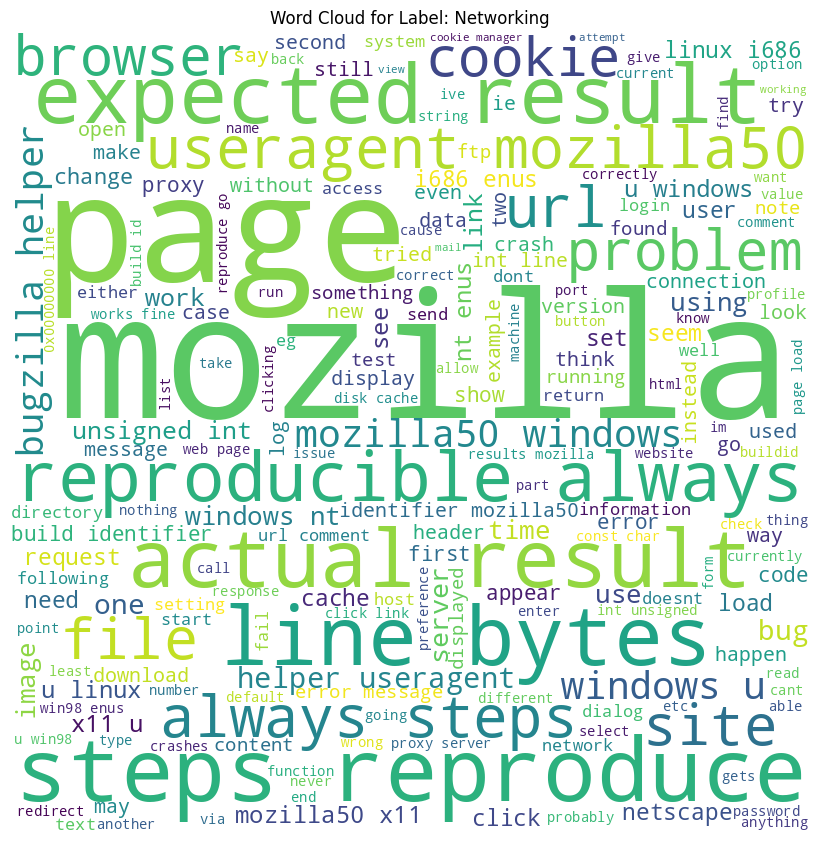

Word Counts for Label: Networking


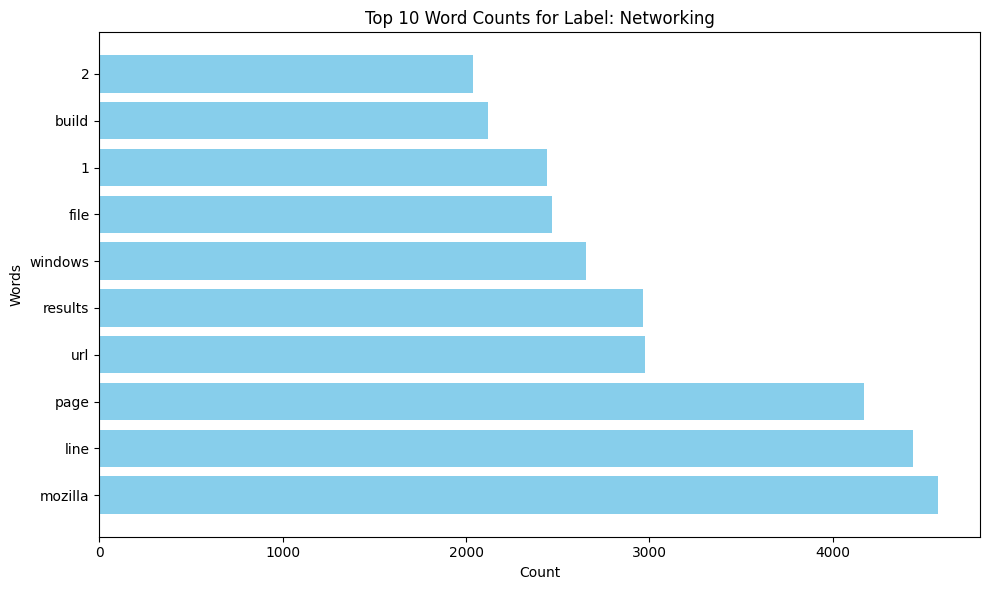

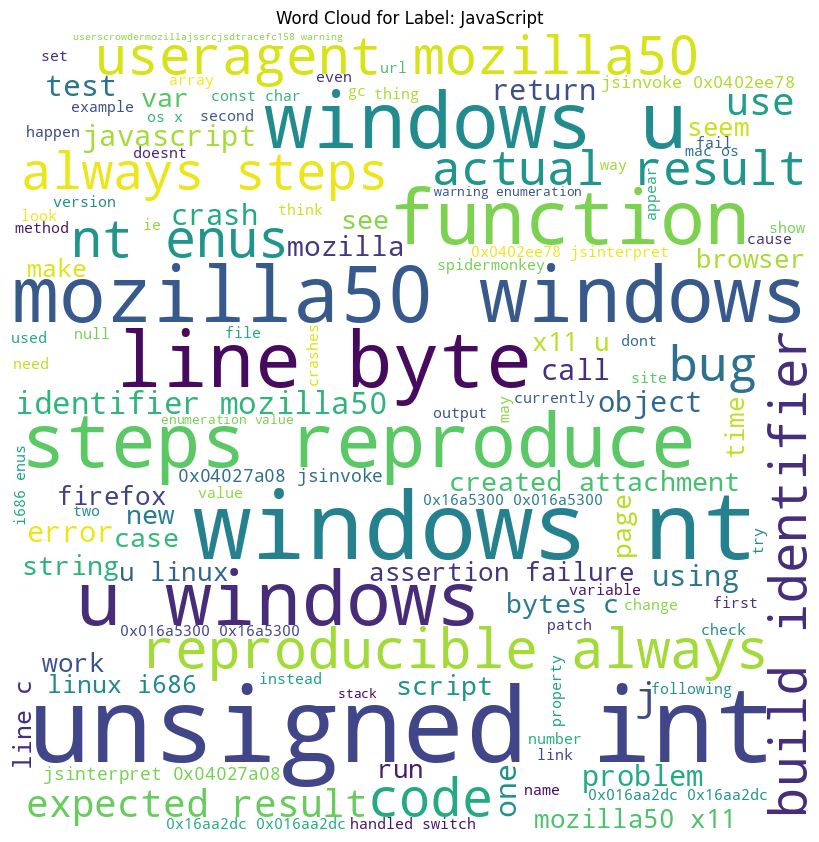

Word Counts for Label: JavaScript


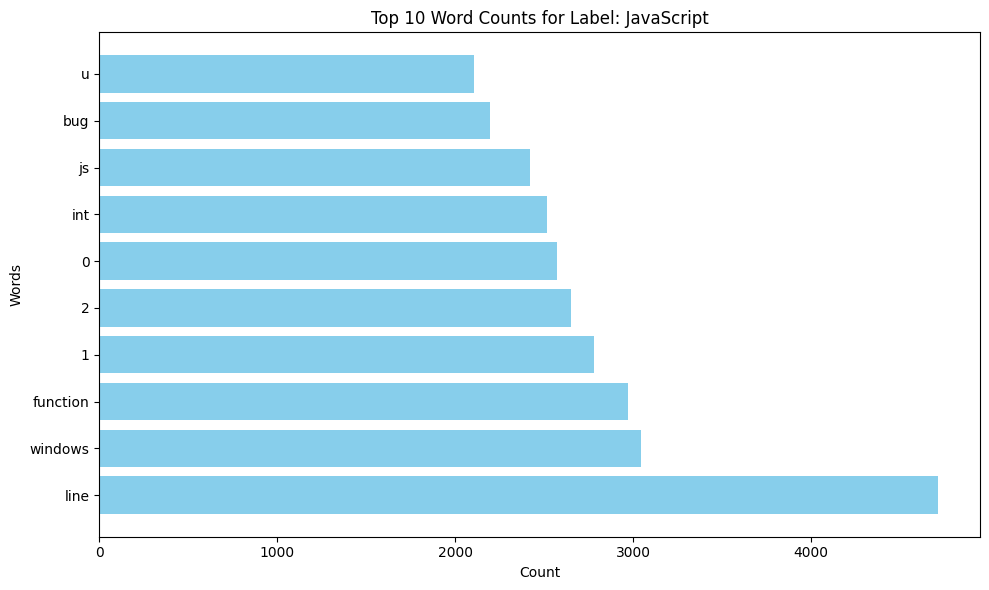

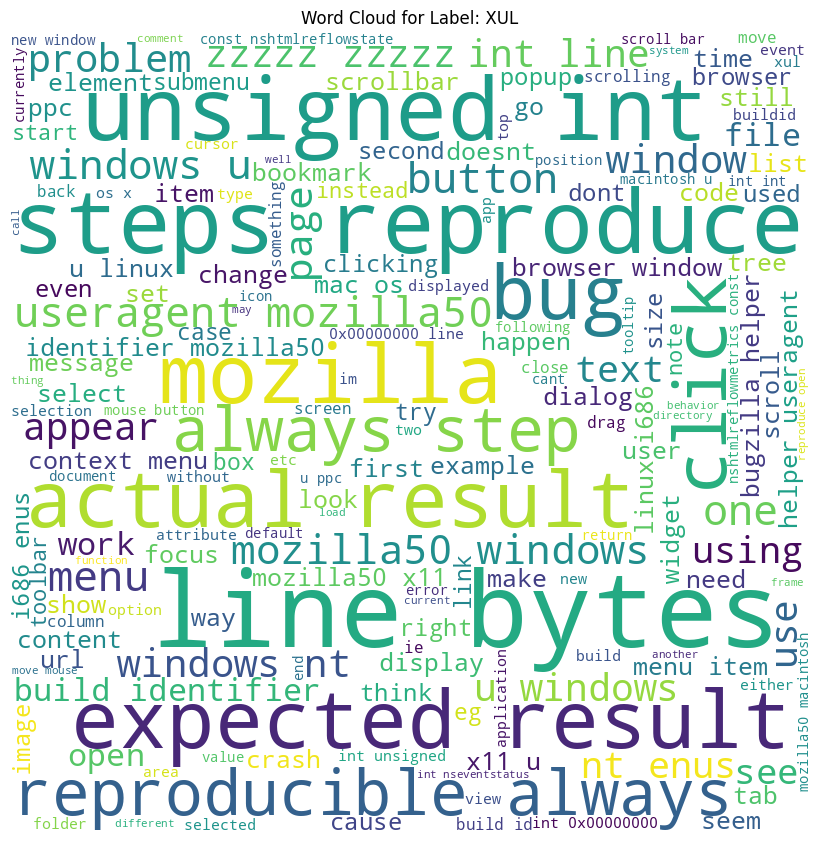

Word Counts for Label: XUL


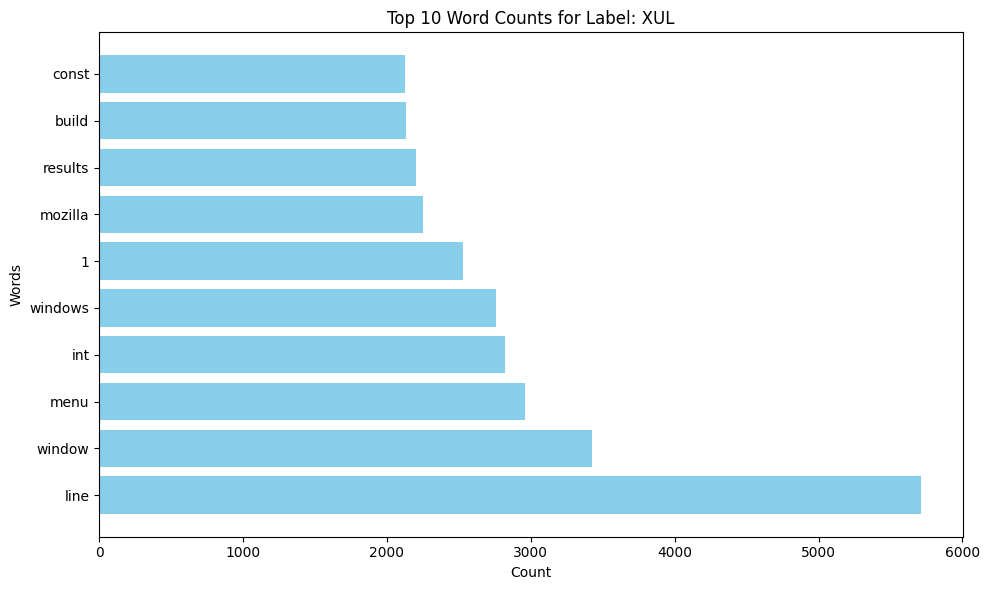

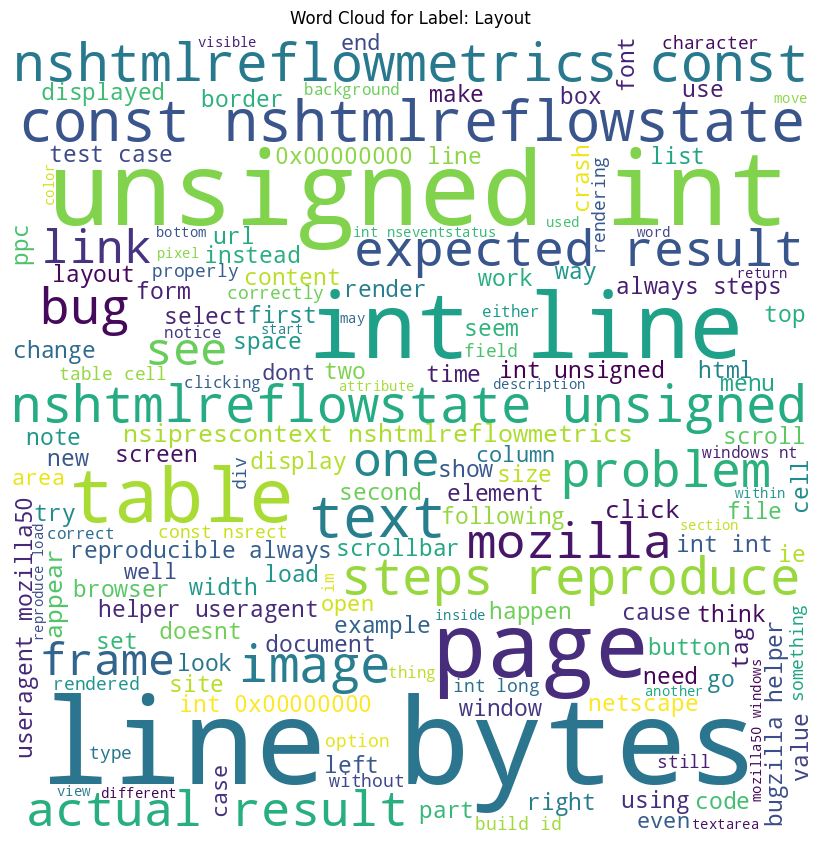

Word Counts for Label: Layout


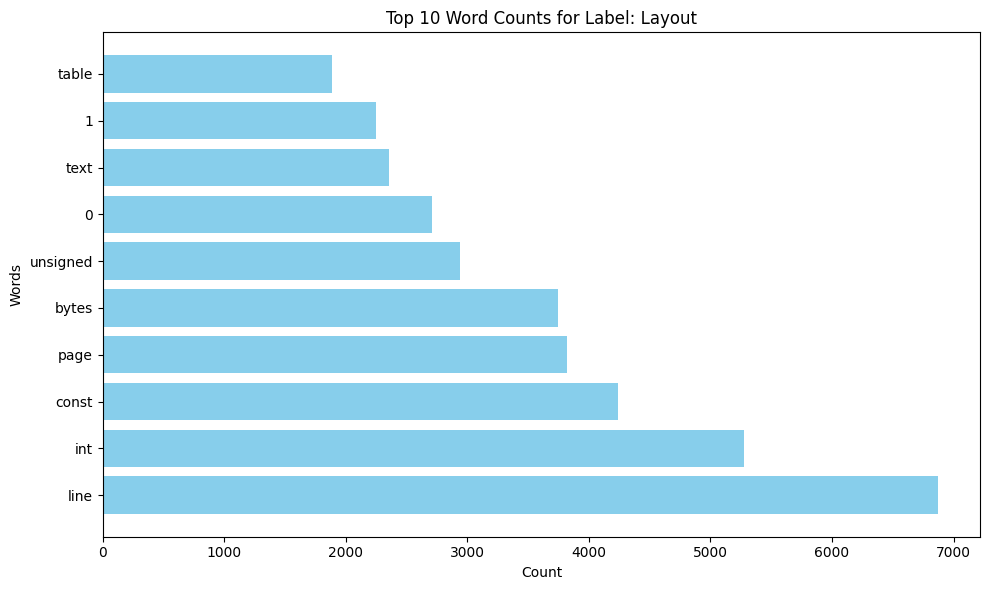

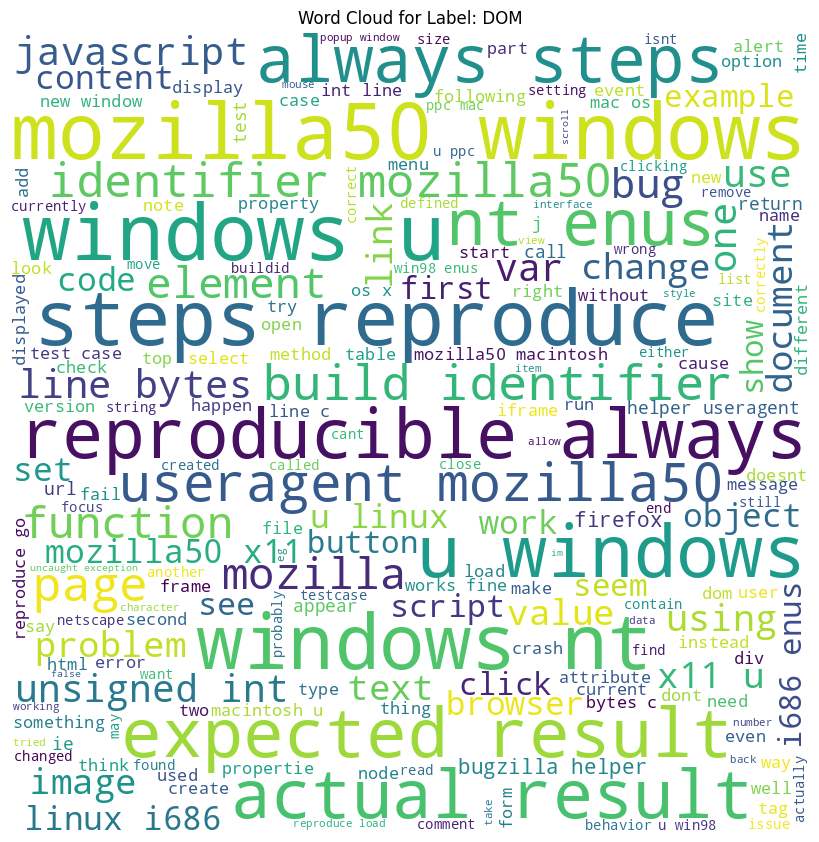

Word Counts for Label: DOM


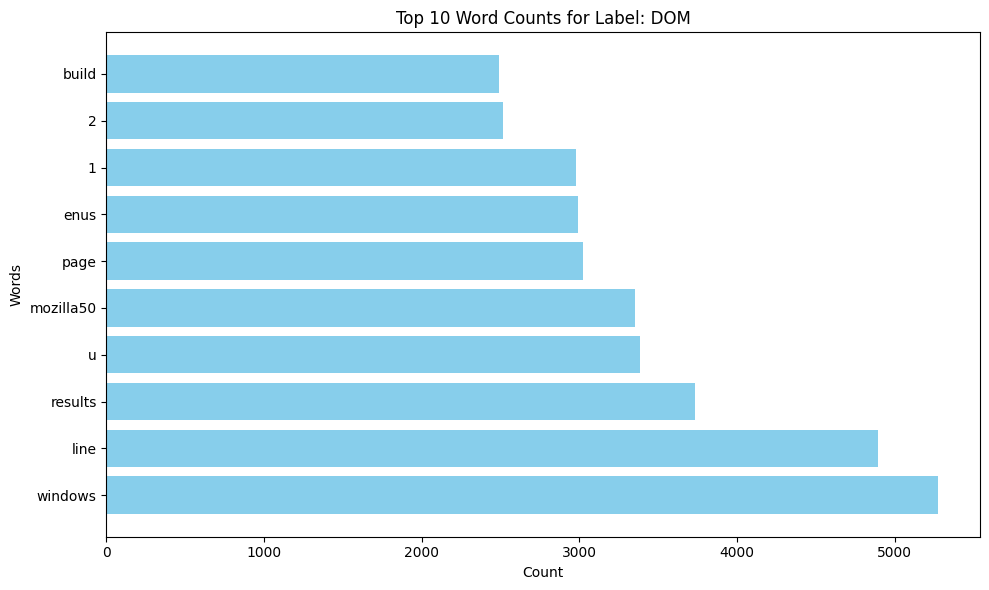

In [75]:


import pandas as pd
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
import nltk

nltk.download('punkt')

# Read the CSV file
df = pd.read_csv('train_mozill_core_preprocessed.csv')

# Convert 'Description' column to strings
df['Description'] = df['Description'].astype(str)

# Iterate through unique labels
for label in df['Component'].unique():
    # Filter rows for the current label
    description = ' '.join(df[df['Component'] == label]['Description'])

    # Tokenize the words
    tokens = word_tokenize(description)

    # Count the occurrences of each word
    word_count = Counter(tokens)

    # Generate word cloud for the current label
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=None,
                          min_font_size=10).generate(description)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    # Set title for the plot
    plt.title(f'Word Cloud for Label: {label}')

    # Show the plot
    plt.show()

    # Display word counts
    print(f"Word Counts for Label: {label}")
    words, counts = zip(*word_count.most_common(10))  # Displaying only top 10 words
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.title(f'Top 10 Word Counts for Label: {label}')
    plt.tight_layout()
    plt.show()
    # break

*Graph for word count analysis in title and Description*

<Figure size 800x800 with 0 Axes>

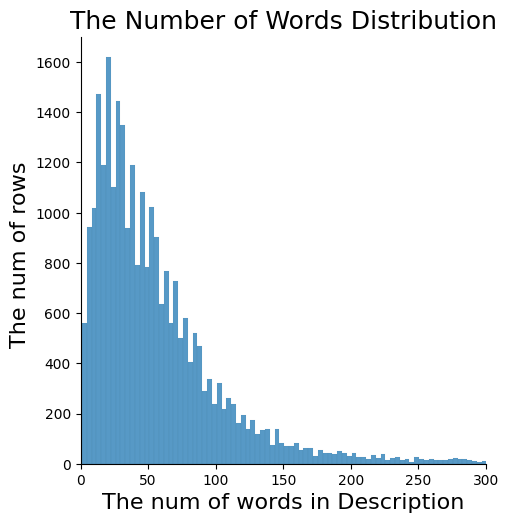

<Figure size 800x800 with 0 Axes>

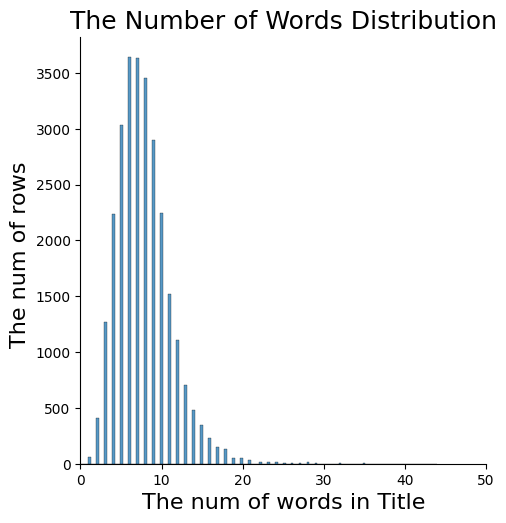

In [76]:


import seaborn as sns

df['count'] = df['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 300)

plt.xlabel('The num of words in Description', fontsize = 16)
plt.ylabel('The num of rows ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

import seaborn as sns

df['count'] = df['Title'].apply(lambda x: len(x.split()))
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 50)

plt.xlabel('The num of words in Title', fontsize = 16)
plt.ylabel('The num of rows ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

*Graph analysis on the different datasets*

10


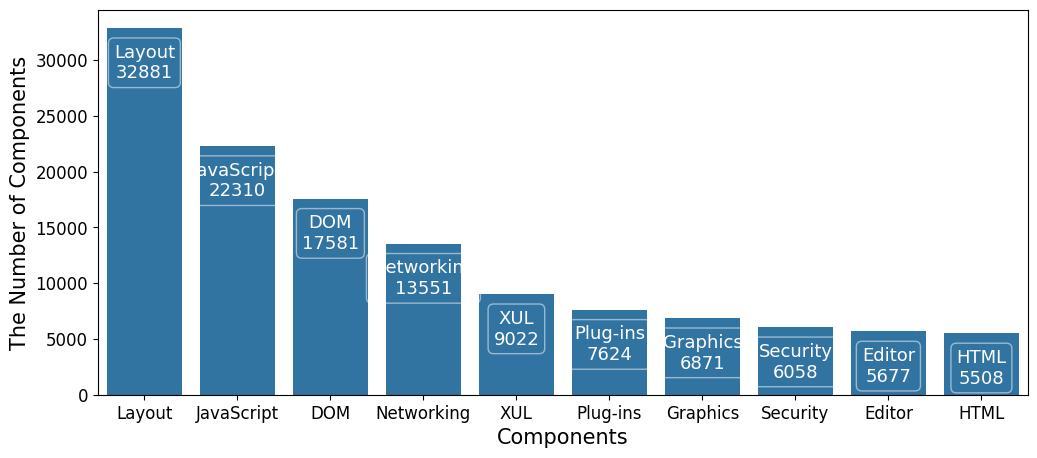

5


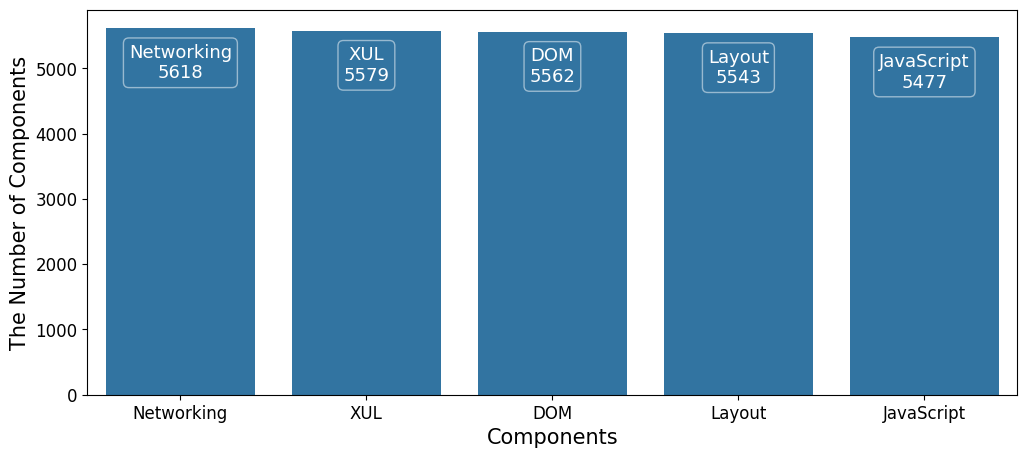

5


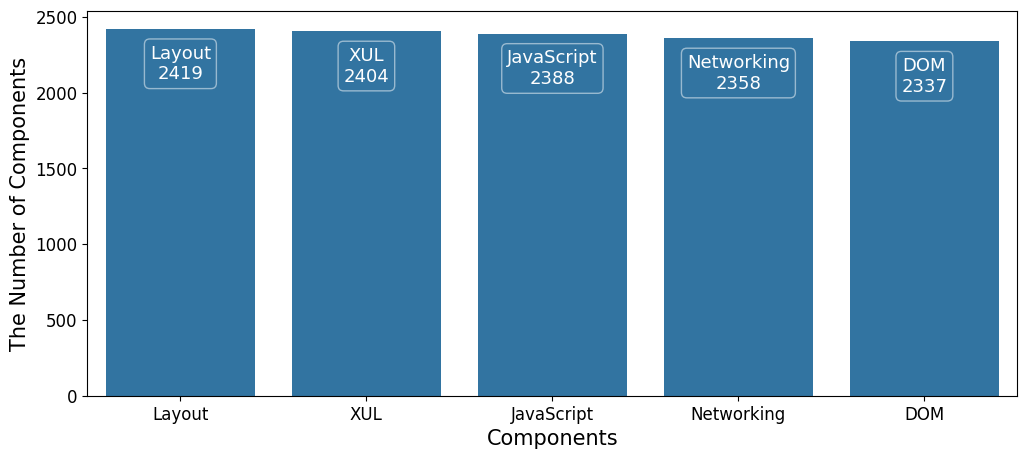

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

def graph_plot(df):
    df['Component'] = df['Component'].str.split().str.get(0).str.split(":").str.get(0)

    # df = df[df["component"] != "General"]

    componets = df.explode("Component")["Component"].value_counts()

    componets_top5 = componets.head(10).index.tolist()
    df = df[df["Component"].apply(lambda x: x in componets_top5)]
    df_filter = pd.DataFrame(columns=df.columns)
    for i in componets_top5:
        componets_rows = df[df["Component"].apply(lambda x: x == i)]
        df_filter = pd.concat([df_filter, componets_rows])
    df = df_filter

    category_count = df['Component'].value_counts()

    categories = category_count.index
    print(len(categories))


    fig = plt.figure(figsize= (12, 5))

    ax = fig.add_subplot(111)

    sns.barplot(x = category_count.index, y = category_count )

    for a, p in enumerate(ax.patches):
        ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

    plt.xlabel('Components', size = 15)

    plt.ylabel('The Number of Components', size= 15)

    plt.xticks(size = 12)

    plt.yticks(size = 12)

    # plt.title("The number of News by Categories" , size = 18)

    plt.show()

graph_plot(pd.read_csv('mozilla_core.csv'))
graph_plot(pd.read_csv('train_mozill_core_preprocessed.csv'))
graph_plot(pd.read_csv('test_mozill_core_preprocessed.csv'))

*Importing the modules for transformer based model implimentation*

In [77]:
# ! pip uninstall transformers -y
# ! pip install transformers
import json
import csv
import re
import string
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

*Distill Bert implimentation for classification*

In [ ]:
# Distill bert

train_data = pd.read_csv("train_mozill_core_preprocessed.csv")
test_data = pd.read_csv("test_mozill_core_preprocessed.csv")
# test_data = train_data

train_data['Title'] = train_data['Description'].fillna('')

# Load the text classification model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)  # Adjust num_labels to 5 for top 5 components
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model.load_state_dict(torch.load('model_checkpoint_epoch_0.h5'))
def train_part_data(train_data_part):
    # Tokenize the text data
    train_encodings = tokenizer(train_data_part['Title'].tolist(), truncation=True, padding=True, return_tensors='pt')
    # test_encodings = tokenizer(train_data_part['Title'].tolist(), truncation=True, padding=True, return_tensors='pt')
    model.load_state_dict(torch.load('complete_model1.h5'))
    # Fine-tune the model
    print("fine-tune started....")
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_encodings.input_ids) // 32)
    model.train()

    train_attention_mask = train_encodings.attention_mask
    # test_attention_mask = test_encodings.attention_mask

    # model.zero_grad()

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Fit label encoder and transform the labels
    encoded_labels = label_encoder.fit_transform(train_data_part['Component'])
    # print(label_encoder)

    # Convert the encoded labels to a PyTorch tensor
    labels_tensor = torch.tensor(encoded_labels)
    # print(encoded_labels)
    for epoch in range(1):
        output = model(train_encodings.input_ids, labels=labels_tensor, attention_mask=train_attention_mask)
        loss = output.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        torch.save(model.state_dict(), f'model_checkpoint_epoch_0.h5')
    print("training ended....")
    return model, label_encoder

# Train the model 50 for each time.
for i in range(int(train_data.shape[0]/50)):
    model, label_encoder = train_part_data(train_data[i*50:(i+1)*50])
    # break

*Testing the trained model*

In [ ]:
test_data = pd.read_csv("test_mozill_core.csv")
# test_data = test_data[:100]
accuracy_list = []
# model.load_state_dict(torch.load('complete_model1.h5'))
def test_part_data(test_data_part):

    test_data_part['Title'] = test_data_part['Description'].fillna('')
    # print(test_data_part['Title'][30] )
    # test_data_part['Title'] = test_data_part['Title'].str.replace('ftp', 'javascript', case=False)
    test_encodings = tokenizer(test_data_part['Title'].tolist(), truncation=True, padding=True, return_tensors='pt')
    test_attention_mask = test_encodings.attention_mask
    model.eval()

    predictions = model(test_encodings.input_ids, attention_mask=test_attention_mask).logits.argmax(axis=1)
    class_predictions = []
    # print(predictions)

    # print(predictions)
    class_predictions = label_encoder.inverse_transform(predictions)
    # print(class_predictions)
    test_data_part['class_prediction'] = class_predictions

    # Evaluate the model
    accuracy = accuracy_score(test_data_part["Component"], test_data_part["class_prediction"])
    accuracy_list.append(accuracy)
    # Print the confusion matrix
    # print(f'Confusion Matrix: {confusion_matrix(test_data["Component"], test_data["class_prediction"])}')

# Calculating the accuracy chunk by chunk
for i in range(int(test_data.shape[0]/100)):
    test_part_data(test_data[i*100:(i+1)*100])
#     break
test_part_data(test_data[60:70])
print("Final Accuracy: ", sum(accuracy_list)/len(accuracy_list))
# Save the results
# test_data.to_csv("result.csv", index=False)